# Settings

In [1]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import tensorflow as tf
import numpy.random as rnd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
%matplotlib inline

import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data

In [2]:
import pickle
import boto3
from io import BytesIO

In [3]:
s3 = boto3.resource('s3')
data_subsets = ['train', 'val']
data = {}

for name in data_subsets:
    with BytesIO() as files:
        path = "omniglot_images/" +name+ ".pickle"
        s3.Bucket("research-paper-omniglot-data").download_fileobj(path, files)
        files.seek(0)    # move back to the beginning after writing
        (X,c) = pickle.load(files)
        data[name] = X

path = '../../omniglot_images/'
data_subsets = ["train", "val", "test"]

data = {}
categories = {}
info = {}
        
for name in data_subsets:
    file_path = os.path.join(path, name + ".pickle")
    print("loading data from {}".format(file_path))
    with open(file_path,"rb") as f:
        (X,c) = pickle.load(f)
        data[name] = X
        categories[name] = c

In [4]:
def create_train_data(size, s='train'):
    #get train data and shape
    X=data[s]
    n_classes, n_examples, w, h = X.shape
    
    #initialize 2 empty arrays for the input size in a list
    pairs=[np.zeros((size, h, w,1)) for i in range(2)]
    
    #initialize vector for the targets
    targets=np.zeros((size,1))
    
    for x in range(size):
        #randomly sample one class (character)
        category = rnd.choice(n_classes,1,replace=False)
        #randomly sample one example from class (1-20 characters)
        idx_1 = rnd.randint(0, n_examples)
        pairs[0][x,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        #randomly sample again one example from class and add last class with modulo
        # ..to ensure not same class pairs are created
        idx_2 = (idx_1 + rnd.randint(0, n_examples)) % n_examples
        #pick images of different class for 1st half and same class for 2nd half
        if x >= size // 2:
            category_2 = category
            targets[x] = 1
        else: 
        #add a random number to the category modulo n classes to ensure 2nd image has
        # ..different category
            idx_2 = rnd.randint(0, n_examples) 
            category_2 = (category + rnd.randint(1,n_classes)) % n_classes
            targets[x] = 0
        pairs[1][x,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
        
    return pairs, targets

In [5]:
train_set, train_labels = create_train_data(10000)
val_set, val_labels = create_train_data(3000)

# Hyperparameter setting

In [6]:
dim_learning_rate = Real(low=1e-7, high=0.1, prior='log-uniform', name='learning_rate')
dim_reg_layer1 = Real(low=0.00000001, high=0.1, prior='log-uniform', name='reg_layer1')
dim_reg_layer2 = Real(low=0.00000001, high=0.1, prior='log-uniform', name='reg_layer2')
dim_reg_layer3 = Real(low=0.00000001, high=0.1, prior='log-uniform', name='reg_layer3')
dim_reg_layer4 = Real(low=0.00000001, high=0.1, prior='log-uniform', name='reg_layer4')
dim_reg_layer5 = Real(low=0.00000001, high=0.1, prior='log-uniform', name='reg_layer5')
dim_filt_layer1 = Integer(3,12, name='filter_layer1')
dim_filt_layer2 = Integer(3,10, name='filter_layer2')
dim_filt_layer3 = Integer(3,8, name='filter_layer3')
dim_filt_layer4 = Integer(3,6, name='filter_layer4')
dim_chan_layer1 = Categorical([16,32,48,64,80,96,112,128,144,160,176,192,208,224,240,256], name='channel_layer1')
dim_chan_layer2 = Categorical([16,32,48,64,80,96,112,128,144,160,176,192,208,224,240,256], name='channel_layer2')
dim_chan_layer3 = Categorical([16,32,48,64,80,96,112,128,144,160,176,192,208,224,240,256], name='channel_layer3')
dim_chan_layer4 = Categorical([16,32,48,64,80,96,112,128,144,160,176,192,208,224,240,256], name='channel_layer4')
dim_fc_layer5 = Categorical([256,512,768,1024,1280,1536,1792,2048,2304,2560,2816,3072,3328,3584,3840,4096], name='channel_layer5')
beta1 = Real(low=0.00001, high=0.9999, prior = 'uniform', name='beta1')
beta2 = Real(low=0.00001, high=0.9999, prior = 'uniform', name='beta2')
batch = Categorical([32,48], name='batch')

In [7]:
dimensions = [dim_learning_rate,
             dim_reg_layer1,
             dim_reg_layer2,
             dim_reg_layer3,
             dim_reg_layer4,
             dim_reg_layer5,
             dim_filt_layer1,
             dim_filt_layer2,
             dim_filt_layer3,
             dim_filt_layer4,
             dim_chan_layer1,
             dim_chan_layer2,
             dim_chan_layer3,
             dim_chan_layer4,
             dim_fc_layer5,
             beta1,
             beta2,
             batch]

In [8]:
default_parameters = [0.00006,2e-4,2e-4,2e-4,2e-4,1e-3,10,7,4,4,64,128,128,256,2048,0.9,0.999,48]

# Create graph

In [9]:
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rnd.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)

In [10]:
def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rnd.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

In [11]:
def create_network(**params):
    input_shape = (105, 105, 1)
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    #build convnet to use in each siamese 'leg'
    convnet = Sequential()
    convnet.add(Conv2D(params['channel_layer1'],(params['filter_layer1'],params['filter_layer1']),activation='relu',input_shape=input_shape,kernel_initializer=W_init,kernel_regularizer=l2(params['reg_layer1']),bias_initializer=b_init))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(params['channel_layer2'],(params['filter_layer2'],params['filter_layer2']),activation='relu',kernel_regularizer=l2(params['reg_layer2']),kernel_initializer=W_init,bias_initializer=b_init))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(params['channel_layer3'],(params['filter_layer3'],params['filter_layer3']),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(params['reg_layer3']),bias_initializer=b_init))
    convnet.add(MaxPooling2D())
    convnet.add(Conv2D(params['channel_layer4'],(params['filter_layer4'],params['filter_layer4']),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(params['reg_layer4']),bias_initializer=b_init))
    convnet.add(Flatten())
    convnet.add(Dense(params['channel_layer5'],activation="sigmoid",kernel_regularizer=l2(params['reg_layer5']),kernel_initializer=W_init,bias_initializer=b_init))
    #call the convnet Sequential model on each of the input tensors so params will be shared
    encoded_l = convnet(left_input)
    encoded_r = convnet(right_input)
    #layer to merge two encoded inputs with the l1 distance between them
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    #call this layer on list of two input tensors.
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    optimizer = Adam(lr=params['learning_rate'], beta_1=params['beta1'], beta_2=params['beta2'])
    siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer)
    #siamese_net.count_params()
    return(siamese_net)

In [12]:
def accuracy(pred, true_val):
    acc_bool = np.equal(np.round_(pred), true_val)
    acc = np.mean(acc_bool.astype(int))
    
    return(acc)

# Training

This is just as fast as the Tensorflow implementation

In [13]:
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))
###################################


@use_named_args(dimensions=dimensions)
def fitness(**params):
    #Training loop
    siamese_net = create_network(**params)
        
    print("!")
    batch_size = params['batch']
    total_batch = int(10000/batch_size)
    total_batch_val = int(3000/batch_size)
    epoch = 10

    print("training")
    for i in range(epoch):
        batch_x1, batch_x2, batch_y = shuffle(train_set[0],train_set[1], train_labels, n_samples = batch_size)
        train_batch_acc = 0
        for j in range(total_batch):
            loss=siamese_net.train_on_batch([batch_x1, batch_x2],batch_y)
            probs = siamese_net.predict([batch_x1, batch_x2])
            train_batch_acc += accuracy(probs, batch_y)
            #print('Loss:', loss)
            #print('Batch:', j)
        train_acc = train_batch_acc/total_batch
        val_batch_acc = 0
        for validation in range(total_batch_val):
            batch_x1, batch_x2, batch_y = shuffle(val_set[0],val_set[1], val_labels, n_samples = batch_size)
            probs = siamese_net.predict([batch_x1, batch_x2])
            val_batch_acc += accuracy(probs, batch_y)
        val_acc = val_batch_acc/total_batch_val
        print('Epoch:', i)
        print('Train accuracy:', train_acc)
        print('Validation accuracy:', val_acc)
            
    return(-val_acc)

In [17]:
fitness(x=default_parameters)

!
training
Loss: 4.4984665
Batch: 0
Loss: 4.403412
Batch: 1
Loss: 4.330426
Batch: 2
Loss: 4.24168
Batch: 3
Loss: 4.1520605
Batch: 4
Loss: 4.066664
Batch: 5
Loss: 3.988257
Batch: 6
Loss: 3.9156978
Batch: 7
Loss: 3.8498886
Batch: 8
Loss: 3.791628
Batch: 9
Loss: 3.7408202
Batch: 10
Loss: 3.6968129
Batch: 11
Loss: 3.658761
Batch: 12
Loss: 3.6255662
Batch: 13
Loss: 3.5960796
Batch: 14
Loss: 3.5691466
Batch: 15
Loss: 3.5438907
Batch: 16
Loss: 3.5197856
Batch: 17
Loss: 3.496443
Batch: 18
Loss: 3.4735928
Batch: 19
Loss: 3.4510489
Batch: 20
Loss: 3.4286983
Batch: 21
Loss: 3.4064739
Batch: 22
Loss: 3.384332
Batch: 23
Loss: 3.3622463
Batch: 24
Loss: 3.3402033
Batch: 25
Loss: 3.318196
Batch: 26
Loss: 3.2962224
Batch: 27
Loss: 3.2742836
Batch: 28
Loss: 3.252379
Batch: 29
Loss: 3.2305143
Batch: 30
Loss: 3.2086942
Batch: 31
Loss: 3.186924
Batch: 32
Loss: 3.165208
Batch: 33
Loss: 3.1435518
Batch: 34
Loss: 3.121961
Batch: 35
Loss: 3.10044
Batch: 36
Loss: 3.078994
Batch: 37
Loss: 3.0576262
Batch: 38
Los

Loss: 1.2194717
Batch: 77
Train accuracy: 0.9955929487179487
Validation accuracy: 0.681046195652174
Loss: 2.047232
Batch: 0
Loss: 1.6528767
Batch: 1
Loss: 1.3625965
Batch: 2
Loss: 1.2733976
Batch: 3
Loss: 1.2483989
Batch: 4
Loss: 1.2347552
Batch: 5
Loss: 1.218029
Batch: 6
Loss: 1.2065902
Batch: 7
Loss: 1.198956
Batch: 8
Loss: 1.192144
Batch: 9
Loss: 1.1861367
Batch: 10
Loss: 1.1815007
Batch: 11
Loss: 1.1777263
Batch: 12
Loss: 1.1742325
Batch: 13
Loss: 1.1709801
Batch: 14
Loss: 1.1680155
Batch: 15
Loss: 1.1651844
Batch: 16
Loss: 1.1623319
Batch: 17
Loss: 1.1594843
Batch: 18
Loss: 1.1567261
Batch: 19
Loss: 1.154084
Batch: 20
Loss: 1.1515338
Batch: 21
Loss: 1.1490407
Batch: 22
Loss: 1.146579
Batch: 23
Loss: 1.144134
Batch: 24
Loss: 1.1416973
Batch: 25
Loss: 1.1392659
Batch: 26
Loss: 1.136837
Batch: 27
Loss: 1.1344097
Batch: 28
Loss: 1.1319836
Batch: 29
Loss: 1.1295587
Batch: 30
Loss: 1.1271353
Batch: 31
Loss: 1.1247138
Batch: 32
Loss: 1.1222942
Batch: 33
Loss: 1.1198772
Batch: 34
Loss: 1.

Loss: 0.6660321
Batch: 69
Loss: 0.66471463
Batch: 70
Loss: 0.66340005
Batch: 71
Loss: 0.66208804
Batch: 72
Loss: 0.6607786
Batch: 73
Loss: 0.6594721
Batch: 74
Loss: 0.65816814
Batch: 75
Loss: 0.6568668
Batch: 76
Loss: 0.6555682
Batch: 77
Train accuracy: 0.9983974358974359
Validation accuracy: 0.7088994565217391
Loss: 1.185165
Batch: 0
Loss: 0.92216676
Batch: 1
Loss: 0.74742746
Batch: 2
Loss: 0.7317742
Batch: 3
Loss: 0.7031685
Batch: 4
Loss: 0.68872476
Batch: 5
Loss: 0.68291694
Batch: 6
Loss: 0.6806782
Batch: 7
Loss: 0.6785071
Batch: 8
Loss: 0.674973
Batch: 9
Loss: 0.67100304
Batch: 10
Loss: 0.6676639
Batch: 11
Loss: 0.665144
Batch: 12
Loss: 0.66321176
Batch: 13
Loss: 0.6616208
Batch: 14
Loss: 0.6601999
Batch: 15
Loss: 0.6588511
Batch: 16
Loss: 0.657523
Batch: 17
Loss: 0.6561891
Batch: 18
Loss: 0.6548443
Batch: 19
Loss: 0.6534978
Batch: 20
Loss: 0.65216553
Batch: 21
Loss: 0.6508656
Batch: 22
Loss: 0.6496026
Batch: 23
Loss: 0.6483559
Batch: 24
Loss: 0.6471102
Batch: 25
Loss: 0.6458692
Ba

-0.7238451086956522

In [14]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=60,
                            x0=default_parameters)

!
training
Epoch: 0
Train accuracy: 0.9990985576923077
Validation accuracy: 0.6112231182795698
Epoch: 1
Train accuracy: 0.9987980769230769
Validation accuracy: 0.574260752688172
Epoch: 2
Train accuracy: 0.9975961538461539
Validation accuracy: 0.5514112903225808
Epoch: 3
Train accuracy: 0.9942908653846154
Validation accuracy: 0.594758064516129
Epoch: 4
Train accuracy: 0.9990985576923077
Validation accuracy: 0.601478494623656
Epoch: 5
Train accuracy: 0.9997996794871795
Validation accuracy: 0.5967741935483871
Epoch: 6
Train accuracy: 0.9997996794871795
Validation accuracy: 0.5910618279569892
Epoch: 7
Train accuracy: 0.9995993589743589
Validation accuracy: 0.6055107526881719
Epoch: 8
Train accuracy: 0.9998998397435896
Validation accuracy: 0.6448252688172044
Epoch: 9
Train accuracy: 0.9997996794871795
Validation accuracy: 0.6236559139784945
!
training
Epoch: 0
Train accuracy: 0.5464743589743603
Validation accuracy: 0.5100806451612903
Epoch: 1
Train accuracy: 0.5454727564102562
Validation ac

Epoch: 7
Train accuracy: 0.6452323717948718
Validation accuracy: 0.5890456989247311
Epoch: 8
Train accuracy: 0.6316105769230769
Validation accuracy: 0.6169354838709677
Epoch: 9
Train accuracy: 0.6993189102564102
Validation accuracy: 0.6085349462365591
!
training
Epoch: 0
Train accuracy: 0.9983974358974359
Validation accuracy: 0.5534274193548387
Epoch: 1
Train accuracy: 0.9987980769230769
Validation accuracy: 0.5467069892473119
Epoch: 2
Train accuracy: 0.9987980769230769
Validation accuracy: 0.5645161290322581
Epoch: 3
Train accuracy: 0.9970953525641025
Validation accuracy: 0.5668682795698925
Epoch: 4
Train accuracy: 0.9996995192307693
Validation accuracy: 0.5356182795698925
Epoch: 5
Train accuracy: 0.9972956730769231
Validation accuracy: 0.5463709677419355
Epoch: 6
Train accuracy: 0.9975961538461539
Validation accuracy: 0.5460349462365591
Epoch: 7
Train accuracy: 0.9976963141025641
Validation accuracy: 0.5137768817204301
Epoch: 8
Train accuracy: 0.9980969551282052
Validation accuracy: 

Epoch: 5
Train accuracy: 0.5865384615384616
Validation accuracy: 0.5033602150537635
Epoch: 6
Train accuracy: 0.5217347756410257
Validation accuracy: 0.5030241935483871
Epoch: 7
Train accuracy: 0.5746193910256411
Validation accuracy: 0.4993279569892473
Epoch: 8
Train accuracy: 0.5969551282051282
Validation accuracy: 0.5063844086021505
Epoch: 9
Train accuracy: 0.7292668269230769
Validation accuracy: 0.5043682795698925
!
training
Epoch: 0
Train accuracy: 0.5416666666666682
Validation accuracy: 0.4862231182795698
Epoch: 1
Train accuracy: 0.4375
Validation accuracy: 0.5023521505376345
Epoch: 2
Train accuracy: 0.4583333333333324
Validation accuracy: 0.5107526881720429
Epoch: 3
Train accuracy: 0.5
Validation accuracy: 0.5043682795698925
Epoch: 4
Train accuracy: 0.5833333333333316
Validation accuracy: 0.5070564516129032
Epoch: 5
Train accuracy: 0.35416666666666646
Validation accuracy: 0.48891129032258057
Epoch: 6
Train accuracy: 0.5625
Validation accuracy: 0.4996639784946238
Epoch: 7
Train acc

Epoch: 5
Train accuracy: 0.8177083333333347
Validation accuracy: 0.6196236559139784
Epoch: 6
Train accuracy: 0.871193910256411
Validation accuracy: 0.5829973118279569
Epoch: 7
Train accuracy: 0.8074919871794891
Validation accuracy: 0.5803091397849459
Epoch: 8
Train accuracy: 0.7935697115384599
Validation accuracy: 0.6703629032258067
Epoch: 9
Train accuracy: 0.8159054487179497
Validation accuracy: 0.6538978494623654
!
training
Epoch: 0
Train accuracy: 0.6644631410256411
Validation accuracy: 0.5332661290322581
Epoch: 1
Train accuracy: 0.8467548076923077
Validation accuracy: 0.510752688172043
Epoch: 2
Train accuracy: 0.8287259615384616
Validation accuracy: 0.5493951612903226
Epoch: 3
Train accuracy: 0.8331330128205128
Validation accuracy: 0.4946236559139785
Epoch: 4
Train accuracy: 0.9082532051282052
Validation accuracy: 0.6018145161290323
Epoch: 5
Train accuracy: 0.8846153846153846
Validation accuracy: 0.5379704301075269
Epoch: 6
Train accuracy: 0.9194711538461539
Validation accuracy: 0.

Epoch: 3
Train accuracy: 0.9986979166666666
Validation accuracy: 0.5349462365591398
Epoch: 4
Train accuracy: 0.9967948717948718
Validation accuracy: 0.5376344086021505
Epoch: 5
Train accuracy: 0.996895032051282
Validation accuracy: 0.5440188172043011
Epoch: 6
Train accuracy: 0.9974959935897436
Validation accuracy: 0.5396505376344086
Epoch: 7
Train accuracy: 0.9965945512820513
Validation accuracy: 0.5698924731182796
Epoch: 8
Train accuracy: 0.99609375
Validation accuracy: 0.5698924731182796
Epoch: 9
Train accuracy: 0.9961939102564102
Validation accuracy: 0.5766129032258065
!
training
Epoch: 0
Train accuracy: 0.8919270833333329
Validation accuracy: 0.5315860215053764
Epoch: 1
Train accuracy: 0.9815705128205128
Validation accuracy: 0.6209677419354838
Epoch: 2
Train accuracy: 0.9908854166666666
Validation accuracy: 0.6276881720430109
Epoch: 3
Train accuracy: 0.9942908653846154
Validation accuracy: 0.6538978494623656
Epoch: 4
Train accuracy: 0.9977964743589745
Validation accuracy: 0.5843413

Epoch: 1
Train accuracy: 0.9892828525641025
Validation accuracy: 0.5759408602150538
Epoch: 2
Train accuracy: 0.9941907051282052
Validation accuracy: 0.5766129032258065
Epoch: 3
Train accuracy: 0.9848758012820513
Validation accuracy: 0.6102150537634409
Epoch: 4
Train accuracy: 0.9842748397435898
Validation accuracy: 0.6075268817204301
Epoch: 5
Train accuracy: 0.9832732371794872
Validation accuracy: 0.6155913978494624
Epoch: 6
Train accuracy: 0.9885817307692307
Validation accuracy: 0.5752688172043011
Epoch: 7
Train accuracy: 0.9827724358974359
Validation accuracy: 0.5997983870967742
Epoch: 8
Train accuracy: 0.9844751602564102
Validation accuracy: 0.5893817204301075
Epoch: 9
Train accuracy: 0.9816706730769231
Validation accuracy: 0.5863575268817204
!
training
Epoch: 0
Train accuracy: 0.4567307692307692
Validation accuracy: 0.4885752688172043
Epoch: 1
Train accuracy: 0.7363782051282052
Validation accuracy: 0.49764784946236557
Epoch: 2
Train accuracy: 0.7862580128205128
Validation accuracy:

Epoch: 9
Train accuracy: 0.91015625
Validation accuracy: 0.6525537634408602
!
training
Epoch: 0
Train accuracy: 0.5625
Validation accuracy: 0.47311827956989255
Epoch: 1
Train accuracy: 0.3333333333333338
Validation accuracy: 0.49966397849462363
Epoch: 2
Train accuracy: 0.4375
Validation accuracy: 0.4993279569892472
Epoch: 3
Train accuracy: 0.612379807692309
Validation accuracy: 0.4926075268817205
Epoch: 4
Train accuracy: 0.6257011217948711
Validation accuracy: 0.5715725806451614
Epoch: 5
Train accuracy: 0.8428485576923072
Validation accuracy: 0.7036290322580645
Epoch: 6
Train accuracy: 0.8626802884615399
Validation accuracy: 0.7093413978494625
Epoch: 7
Train accuracy: 0.8194110576923092
Validation accuracy: 0.6498655913978494
Epoch: 8
Train accuracy: 0.7815504807692305
Validation accuracy: 0.7221102150537634
Epoch: 9
Train accuracy: 0.8609775641025662
Validation accuracy: 0.7399193548387095


In [15]:
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

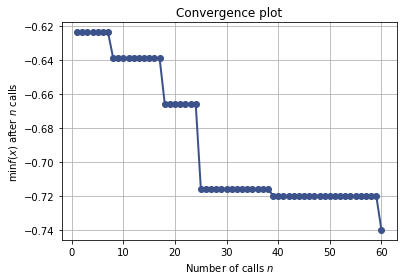

In [16]:
plot_convergence(search_result)

In [ ]:
_ = plot_objective(search_result)

In [17]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(-0.7399193548387095,
  [3.2765338536539206e-07,
   4.8134311006773297e-05,
   0.0006242765412407358,
   1.037203178084381e-07,
   1e-08,
   3.9432125323605935e-08,
   11,
   4,
   5,
   3,
   192,
   48,
   112,
   64,
   3584,
   1e-05,
   0.5224310846332395,
   48]),
 (-0.719758064516129,
  [4.825880554313875e-07,
   2.9452322822804706e-06,
   0.0004939851502951343,
   2.2362840911377307e-07,
   1e-08,
   0.004050462111222351,
   11,
   3,
   4,
   4,
   160,
   256,
   176,
   112,
   1280,
   0.2507180516243929,
   0.8752709591633175,
   48]),
 (-0.7157258064516129,
  [1e-07,
   1.6063123836119204e-06,
   0.00041913458591738117,
   1.087258439661984e-05,
   1.4258996203117195e-08,
   0.00045690114319893937,
   12,
   7,
   8,
   5,
   240,
   256,
   144,
   160,
   1280,
   0.9999,
   0.07166075362238511,
   48]),
 (-0.7133736559139785,
  [3.633914639316309e-07,
   4.161396168274266e-05,
   0.0011259797494248196,
   2.2563351741885868e-07,
   1.4871600468513406e-08,
   0.0001036

In [18]:
search_result.x

[3.2765338536539206e-07,
 4.8134311006773297e-05,
 0.0006242765412407358,
 1.037203178084381e-07,
 1e-08,
 3.9432125323605935e-08,
 11,
 4,
 5,
 3,
 192,
 48,
 112,
 64,
 3584,
 1e-05,
 0.5224310846332395,
 48]